#### Sandbox Demo for CSC

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

import random
import os
import yaml

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import sparse_coding_classifier_functions as scc

from AuxiliaryFunctions import showFilters

%pdb on

Automatic pdb calling has been turned ON


Defining Model Class and functions:

In [2]:
# Training Function

def train_SL_CSC(CSC, train_loader, num_epochs, T_DIC, cost_function, optimizer, batch_size):	
    
    print("Training SL-CSC. Batch size is: " + repr(batch_size))
    
    # Initialise variables needed to plot a random sample of three kernels as they are trained
    filter_dims = list(np.shape(CSC.D_trans.weight.data.numpy()))
    idx = random.sample(range(0, filter_dims[0]), 3)
    plt.ion()
    plt.show()
    for epoch in range(num_epochs):
        print("Training epoch " + repr(epoch+1) + " of " + repr(num_epochs))
        for i, (inputs, labels) in enumerate(train_loader):
            print("Batch number " + repr(i+1))
            inputs = Variable(inputs)
            labels = Variable(labels)
            # Calculate and update step size for sparse coding step
            input_dims = list(inputs.size())
            # Fix dictionary and calculate sparse code
            if CSC.forward_type == 'FISTA_fixed_step':
                CSC.calc_L(input_dims)
            X = CSC.forward(inputs)
            # Fix sparse code and update dictionary
            print("Running dictionary update")
            for j in range(T_DIC):
                # Zero the gradient
                optimizer.zero_grad()
                # Calculate estimate of reconstructed Y
                inputs_recon = CSC.reverse(X)
                # Calculate loss according to the defined cost function between the true Y and reconstructed Y
                loss = cost_function(inputs_recon, inputs)
                # Calculate the gradient of the cost function wrt to each parameters
                loss.backward()
                # Update each parameter according to the optimizer update rule (single step)
                optimizer.step()
                # At the end of each batch plot a random sample of kernels to observe progress
                if j==0 or (j+1)%20 == 0:
                    print("Average loss per data point at iteration {0:1.0f}".format(j+1) + " of SGD: {0:1.4f}".format(np.asscalar(loss.data.numpy())))
                    plt.figure(1)
                    plt.subplot(1,3,1)
                    plt.imshow((CSC.D.weight[idx[0]][0].data.numpy()), cmap='gray')
                    plt.title("Filter "+repr(idx[0]))
                    plt.subplot(1,3,2)
                    plt.imshow((CSC.D.weight[idx[1]][0].data.numpy()), cmap='gray', )
                    plt.title("Filter "+repr(idx[1]))
                    plt.xlabel("Epoch Number: " + repr(epoch)+ ", Batch number: " + repr(i+1) + ", Average loss: {0:1.4f}".format(np.asscalar(loss.data.numpy())))
                    plt.subplot(1,3,3)
                    plt.imshow((CSC.D.weight[idx[2]][0].data.numpy()), cmap='gray')
                    plt.title("Filter "+repr(idx[2]))
                    plt.draw()
                    plt.pause(0.001)			

            l2_error_percent = 100*np.sum((inputs-CSC.D(X)).data.numpy()**2)/ np.sum((inputs).data.numpy()**2)
            print("After " +repr(j+1) + " iterations of SGD, average l2 error over batch: {0:1.2f}".format(l2_error_percent) + "%")
            # Normalise each atom / kernel
            CSC.normalise_weights()
            # Ensure that weights for the reverse and forward operations are consistent	
            CSC.D_trans.weight.data = CSC.D.weight.data.permute(0,1,3,2)
    # Return trained CSC
    return CSC


In [3]:

class SL_CSC_IHT(nn.Module):
    def __init__(self, stride=1, dp_channels=1, atom_r=1, atom_c=1, numb_atom=1, T_SC=1, k=1):
        super(SL_CSC_IHT, self).__init__()
        self.D_trans = nn.Conv2d(dp_channels, numb_atom, (atom_r, atom_c), stride, padding=0, dilation=1, groups=1, bias=False)
        self.D = nn.ConvTranspose2d(numb_atom, dp_channels, (atom_c, atom_r), stride, padding=0, output_padding=0, groups=1, bias=False, dilation=1)
        self.normalise_weights()
        self.D_trans.weight.data = self.D.weight.data.permute(0,1,3,2)
        self.k = k
        self.T_SC=T_SC
        self.forward_type = 'IHT'

    def forward(self, Y):
        y_dims = list(Y.data.size())
        w_dims = list(self.D_trans.weight.data.size())
        # Initialise X as zerio tensor
        X = Variable(torch.zeros(y_dims[0], w_dims[0], (y_dims[2]-w_dims[2]+1),(y_dims[3]-w_dims[3]+1)))
        for i in range(0, self.T_SC):
            # Hard threshold each image in the dataset
            X, l2_error, alpha = self.linesearch(Y,X)
            
        av_num_zeros_per_image = X.data.nonzero().numpy().shape[0]/y_dims[0]
        percent_zeros_per_image = 100*av_num_zeros_per_image/(y_dims[2]*y_dims[3])
        # pix_error = l2_error/(y_dims[0]*y_dims[2]*y_dims[3])
        error_percent = l2_error*100/(np.sum((Y).data.numpy()**2))
        print("IHT results: L2 error over batch: {0:1.2f}".format(error_percent) + "% , Av. sparsity: {0:1.2f}".format(percent_zeros_per_image) +"%")
                
        return X


    def linesearch(self,Y,X):
        # Define search parameter for Armijo method
        c = 0.5
        alpha = .1
        g = self.D_trans(Y-self.D(X))
        HT_arg = X + alpha*g
        X_update, sup = hard_threshold_k(HT_arg, self.k)
        # Calculate cost of current X location
        l2_error_start = np.sum((Y-self.D(X)).data.numpy()**2)
        # Calculate cost of first suggested update
        l2_error = np.sum((Y-self.D(X_update)).data.numpy()**2)
        # While the cost at the next location is higher than the current one iterate up to a count of 8
        count = 0
        while l2_error >= l2_error_start  and count<=15:
            alpha = alpha*c
            HT_arg = X + alpha*g
            X_update, sup = hard_threshold_k(HT_arg, self.k)
            l2_error = np.sum((Y-self.D(X_update)).data.numpy()**2)
            count +=1
        # print("l2 error at end of linesearch step:{0:1.2f}".format(l2_error))
        return X_update, l2_error, alpha

    
    def reverse(self, x):
        out = self.D(x)
        return out

    def normalise_weights(self):
        filter_dims = list(np.shape(self.D.weight.data.numpy()))
        for i in range(filter_dims[0]):
            for j in range(filter_dims[1]):
                self.D.weight.data[i][j] = self.D.weight.data[i][j]/((np.sum(self.D.weight.data[i][j].numpy()**2))**0.5)



Defining Paramters and loading data

In [ ]:
# Training hyperparameters
num_epochs = 1 #100
batch_size = 2000
T_SC = 5
T_DIC = 60
stride = 1
learning_rate = 0.6
momentum = 0.9
weight_decay=0
k = 30

# Local dictionary dimensions
atom_r = 28
atom_c = 28
numb_atom = 1000
dp_channels = 1 

# Weight importance of sparsity vs. reconstruction
tau = 0.9

# Local dictionary dimensions
atom_r = 28
atom_c = 28
numb_atom = 100
dp_channels = 1 

# Load MNIST
root = './data'
download = False  # download MNIST dataset or not

# Access MNIST dataset and define processing transforms to proces
# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor()])
train_set = dsets.MNIST(root=root, train=True, transform=trans, download=download)
test_set = dsets.MNIST(root=root, train=False, transform=trans)

idx = list(range(10000))
train_sampler = SubsetRandomSampler(idx)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 sampler = train_sampler,# None
                 shuffle=False) #True


test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

# Intitilise Convolutional Sparse Coder CSC
CSC = SL_CSC_IHT(stride, dp_channels, atom_r, atom_c, numb_atom, T_SC, k)

# Define optimisation parameters
CSC_parameters = [{'params': CSC.D.parameters()}]

# Define training settings/ options
cost_function = nn.MSELoss(size_average=True)
optimizer = torch.optim.SGD(CSC_parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
# optimizer = torch.optim.Adam(SSC.parameters(), lr=learning_rate)

Training!

Training SL-CSC. Batch size is: 256
Training epoch 1 of 1
Batch number 1
Running FISTA to recover/ estimate sparse code
Number of iterations running FISTA for: 50
After 1 iterations of FISTA, average l2 error over batch: 100.03% , Av. sparsity per image: 0.79%
After 5 iterations of FISTA, average l2 error over batch: 100.07% , Av. sparsity per image: 0.30%
After 10 iterations of FISTA, average l2 error over batch: 100.07% , Av. sparsity per image: 0.30%
After 15 iterations of FISTA, average l2 error over batch: 100.07% , Av. sparsity per image: 0.30%
After 20 iterations of FISTA, average l2 error over batch: 100.07% , Av. sparsity per image: 0.30%
After 25 iterations of FISTA, average l2 error over batch: 100.08% , Av. sparsity per image: 0.29%
After 30 iterations of FISTA, average l2 error over batch: 100.08% , Av. sparsity per image: 0.29%
After 35 iterations of FISTA, average l2 error over batch: 100.08% , Av. sparsity per image: 0.29%
After 40 iterations of FISTA, average l2 error 

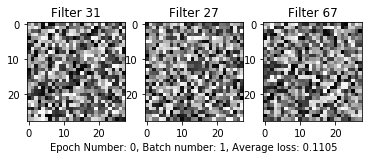

After 10 iterations of SGD, average l2 error over batch: 96.38%
Normalising kernels
Batch number 2
Running FISTA to recover/ estimate sparse code
Number of iterations running FISTA for: 50
After 1 iterations of FISTA, average l2 error over batch: 84.34% , Av. sparsity per image: 2.04%
After 5 iterations of FISTA, average l2 error over batch: 84.30% , Av. sparsity per image: 1.53%
After 10 iterations of FISTA, average l2 error over batch: 84.28% , Av. sparsity per image: 1.39%
After 15 iterations of FISTA, average l2 error over batch: 84.28% , Av. sparsity per image: 1.36%
After 20 iterations of FISTA, average l2 error over batch: 84.30% , Av. sparsity per image: 1.44%
After 25 iterations of FISTA, average l2 error over batch: 84.32% , Av. sparsity per image: 1.42%
After 30 iterations of FISTA, average l2 error over batch: 84.35% , Av. sparsity per image: 1.40%
After 35 iterations of FISTA, average l2 error over batch: 84.35% , Av. sparsity per image: 1.41%
After 40 iterations of FISTA,

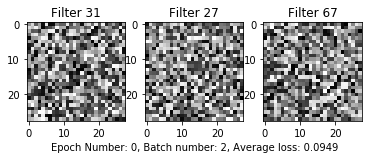

After 10 iterations of SGD, average l2 error over batch: 59.48%
Normalising kernels
Batch number 3
Running FISTA to recover/ estimate sparse code
Number of iterations running FISTA for: 50
After 1 iterations of FISTA, average l2 error over batch: 92.41% , Av. sparsity per image: 3.75%
After 5 iterations of FISTA, average l2 error over batch: 67.57% , Av. sparsity per image: 2.24%
After 10 iterations of FISTA, average l2 error over batch: 61.76% , Av. sparsity per image: 1.68%
After 15 iterations of FISTA, average l2 error over batch: 60.64% , Av. sparsity per image: 1.62%
After 20 iterations of FISTA, average l2 error over batch: 59.30% , Av. sparsity per image: 1.66%
After 25 iterations of FISTA, average l2 error over batch: 58.87% , Av. sparsity per image: 1.57%
After 30 iterations of FISTA, average l2 error over batch: 58.45% , Av. sparsity per image: 1.56%
After 35 iterations of FISTA, average l2 error over batch: 58.29% , Av. sparsity per image: 1.57%
After 40 iterations of FISTA,

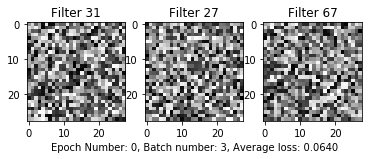

After 10 iterations of SGD, average l2 error over batch: 50.36%
Normalising kernels
Batch number 4
Running FISTA to recover/ estimate sparse code
Number of iterations running FISTA for: 50
After 1 iterations of FISTA, average l2 error over batch: 88.64% , Av. sparsity per image: 3.83%
After 5 iterations of FISTA, average l2 error over batch: 64.59% , Av. sparsity per image: 2.25%
After 10 iterations of FISTA, average l2 error over batch: 55.57% , Av. sparsity per image: 1.72%
After 15 iterations of FISTA, average l2 error over batch: 53.74% , Av. sparsity per image: 1.64%
After 20 iterations of FISTA, average l2 error over batch: 52.07% , Av. sparsity per image: 1.60%
After 25 iterations of FISTA, average l2 error over batch: 51.12% , Av. sparsity per image: 1.60%
After 30 iterations of FISTA, average l2 error over batch: 50.48% , Av. sparsity per image: 1.58%
After 35 iterations of FISTA, average l2 error over batch: 50.16% , Av. sparsity per image: 1.60%
After 40 iterations of FISTA,

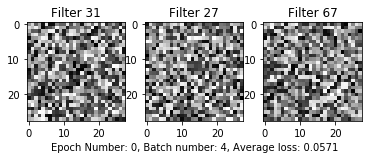

After 10 iterations of SGD, average l2 error over batch: 45.18%
Normalising kernels
Batch number 5
Running FISTA to recover/ estimate sparse code
Number of iterations running FISTA for: 50
After 1 iterations of FISTA, average l2 error over batch: 78.55% , Av. sparsity per image: 3.86%
After 5 iterations of FISTA, average l2 error over batch: 60.34% , Av. sparsity per image: 2.17%
After 10 iterations of FISTA, average l2 error over batch: 54.63% , Av. sparsity per image: 1.72%


KeyboardInterrupt: 

> /home/jere/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py(192)conv_transpose2d()
    190                 _pair(output_padding), groups, torch.backends.cudnn.benchmark,
    191                 torch.backends.cudnn.deterministic, torch.backends.cudnn.enabled)
--> 192     return f(input, weight, bias)
    193 
    194 

--KeyboardInterrupt--
--KeyboardInterrupt--
--KeyboardInterrupt--


In [4]:
CSC = train_SL_CSC(CSC, train_loader, num_epochs, T_DIC, cost_function, optimizer, batch_size)